In [97]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
font = {'size': 16}
matplotlib.rc('font', **font)

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [4]:
data_directory = './ecephys_cache' # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

In [5]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [6]:
sessions = cache.get_session_table()

print('Total number of sessions: ' + str(len(sessions)))

Total number of sessions: 58


In [7]:
filtered_sessions = sessions[(sessions.full_genotype.str.find('Sst') > -1) & \
                             (sessions.session_type == 'brain_observatory_1.1') & \
                             (['VISp' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

print(len(filtered_sessions))
filtered_sessions.head()

6


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
756029989,2019-10-03T00:00:00Z,734865738,brain_observatory_1.1,96.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,684,2214,6,"[TH, DG, CA3, CA1, VISl, nan, PO, Eth, LP, VIS..."
758798717,2019-10-03T00:00:00Z,735109609,brain_observatory_1.1,102.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,593,1486,4,"[MGv, MGd, TH, DG, CA1, VISal, nan, SGN, LP, S..."
760693773,2019-10-03T00:00:00Z,738651054,brain_observatory_1.1,110.0,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,826,2233,6,"[grey, VISrl, nan, VISal, VISp, VISpm, VISam]"


In [8]:
session_id = 715093703  # based on the above filter
session = cache.get_session_data(session_id)

In [9]:
units = cache.get_units()

In [10]:
unit_ids = units[(units.ecephys_structure_acronym=="VISp") & (units.specimen_id==filtered_sessions.specimen_id[session_id])].index
unit_ids.shape

(60,)

# Static Grating Classification
## Controlled orientation decoding

In [27]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="static_gratings"]
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
17,5381.988653,5862.389913,480.40126,static_gratings,8
23,7183.510123,7663.911423,480.40130,static_gratings,11
29,8594.688933,9135.140323,540.45139,static_gratings,14


In [28]:
stims = session.get_stimulus_table(['static_gratings'])
stims = stims[stims.orientation!='null']

In [19]:
filtered_stims = stims[(stims.phase=="0.0") & (stims.spatial_frequency=="0.04")]
filtered_stims

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,
49437,0.8,60,0.0,"[250.0, 250.0]",0.04,5383.239686,8,static_gratings,5383.489905,0.250219,4792
49443,0.8,30,0.0,"[250.0, 250.0]",0.04,5384.740946,8,static_gratings,5384.991147,0.250201,4798
49448,0.8,90,0.0,"[250.0, 250.0]",0.04,5385.991973,8,static_gratings,5386.242184,0.250211,4803
49456,0.8,30,0.0,"[250.0, 250.0]",0.04,5387.993653,8,static_gratings,5388.243862,0.250209,4798
49460,0.8,30,0.0,"[250.0, 250.0]",0.04,5388.994487,8,static_gratings,5389.244699,0.250211,4798
...,...,...,...,...,...,...,...,...,...,...,...
70301,0.8,150,0.0,"[250.0, 250.0]",0.04,9113.372172,14,static_gratings,9113.622370,0.250199,4838
70314,0.8,150,0.0,"[250.0, 250.0]",0.04,9116.624855,14,static_gratings,9116.875054,0.250199,4838
70361,0.8,150,0.0,"[250.0, 250.0]",0.04,9128.384686,14,static_gratings,9128.634885,0.250199,4838


In [20]:
filtered_stims.shape

(294, 11)

In [21]:
num_bins = 10
stim_duration = filtered_stims.duration.min()  # minimum so that none of the recording periods are overlapping
bin_edges = np.linspace(0, stim_duration, num_bins + 1)
counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                               stimulus_presentation_ids=filtered_stims.index,
                                               unit_ids=unit_ids)

In [22]:
oris = np.unique(filtered_stims.orientation).astype(int)
oris

array([  0,  30,  60,  90, 120, 150])

In [23]:
avg_resp = np.mean(counts, axis=0)

C:\Users\ATMal\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.launch_new_instance()


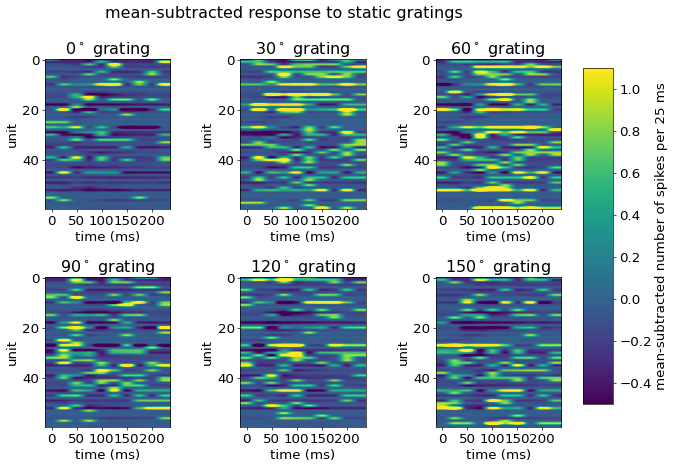

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8), dpi=60)
fig.suptitle("mean-subtracted response to static gratings")
for i, ori in enumerate(oris):
    plt.subplot(2, 3, i+1)
    idxs = filtered_stims[filtered_stims.orientation==ori].index
    plt.ylabel("unit")
    plt.xlabel("time (ms)")
#     im = plt.imshow((np.mean(counts.loc[idxs], axis=0).T - avg_resp), aspect=0.2, vmin=-0.5, vmax=1.1)
    im = plt.imshow(counts.loc[idxs[0]].T - avg_resp, aspect=0.2, vmin=-0.5, vmax=1.1)
    ax = plt.gca()
    ax.set_xticks(np.arange(0, num_bins, 2))
    ax.set_xticklabels((2000 * np.arange(num_bins // 2) * stim_duration / num_bins).astype(int))
    plt.title(f"{ori}$^\circ$ grating")
cbar_ax = fig.add_axes([1.0, 0.15, 0.05, 0.7])
fig.colorbar(mappable=im, label=f"mean-subtracted number of spikes per {int(1000 * stim_duration / num_bins)} ms", cax=cbar_ax)
plt.tight_layout()
plt.show()

## Data preprocessing and PCA

In [522]:
np.random.seed(10)

In [523]:
Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
labels = np.array(list(filtered_stims.orientation))

# train test split
train_frac = 0.7
train_idxs = np.array([], dtype=int)
test_idxs = np.array([], dtype=int)
for label in np.unique(labels):
    matches = np.nonzero(labels == label)[0]
    np.random.shuffle(matches)
    train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
    test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])

In [524]:
Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

In [525]:
proj_rank = 20
train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
test = Xc_test @ Vh.T[:, :proj_rank]

<IPython.core.display.Javascript object>


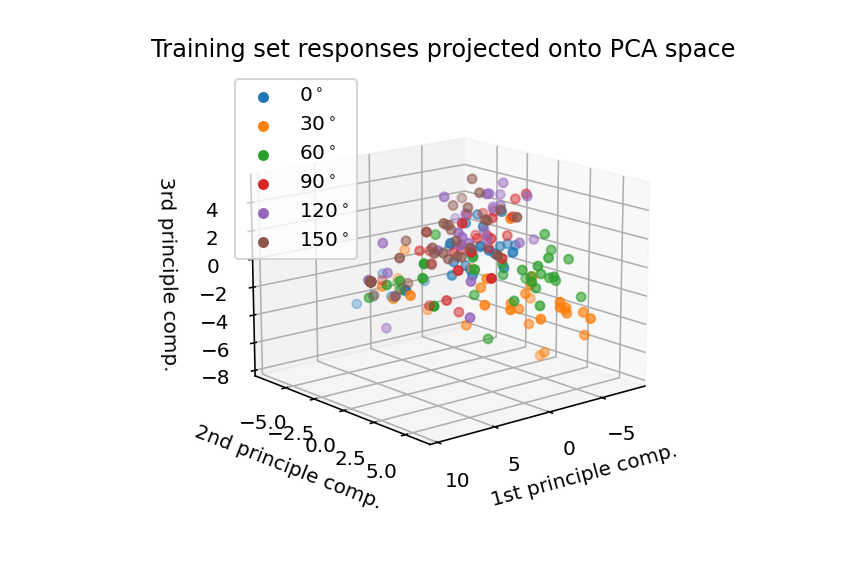

In [526]:
%matplotlib notebook
sample_size = 2000  # all
fig = plt.figure(dpi=120)
ax = fig.gca(projection='3d')
plt.title("Training set responses projected onto PCA space")
# for ori in oris[[1,3]]:
for ori in oris:
    ori_ims = train[np.nonzero(labels[train_idxs]==ori)[0], :3][:sample_size // len(oris)]
    ax.scatter(ori_ims[:, 0], ori_ims[:, 1], ori_ims[:, 2], label=f"{ori}$^\circ$")
ax.view_init(elev=15, azim=50)
plt.xlabel("1st principle comp.")
plt.ylabel("2nd principle comp.")
ax.set_zlabel("3rd principle comp.")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


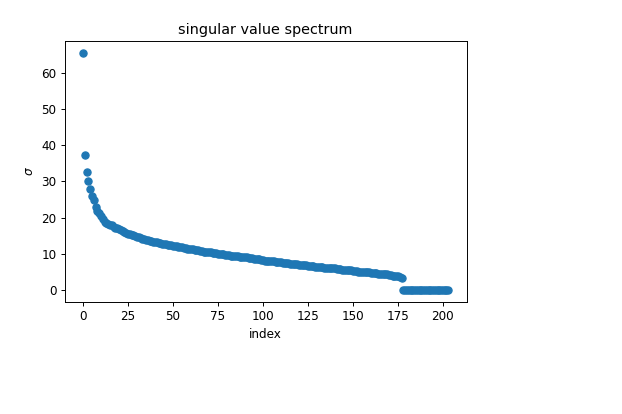

In [528]:
plt.figure()
plt.scatter(np.arange(len(S)), S)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.title("singular value spectrum")
plt.show()

In [531]:
len(S), S[177], S[178]

(204, 3.426418457037982, 1.3229318255165724e-14)

In [532]:
def mutual_info(conf_mat):
    response_freqs = np.sum(conf_mat, axis=0) / np.sum(conf_mat)
    resp_entropy = -np.sum(response_freqs * np.log2(response_freqs + 0.00001))  # bits
    print(resp_entropy)
    stim_entropy = 0
    for i in range(conf_mat.shape[0]):
        response_freqs = conf_mat[i] / np.sum(conf_mat[i])
        stim_entropy += -np.sum(response_freqs * np.log2(response_freqs + 0.00001))
    stim_entropy /= conf_mat.shape[0]
    return resp_entropy - stim_entropy

# covariance classification

In [533]:
avgs = []
stds = []
train_avg = np.mean(Xc_train, axis=0)
for ori in oris:
    idxs = np.nonzero(labels[train_idxs]==ori)
    avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
    stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

In [534]:
def covar_classify(Xc, avgs, oris):
    pre = []
    for response in Xc:
        covars = []
        for avg in avgs:
            covars.append(np.mean(avg.T @ response))
        ori_idx = np.argmax(covars)
        pre.append(oris[ori_idx])
    return pre

In [586]:
def covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, oris, return_minfo=False):
    fit = covar_classify(Xc_train, avgs, oris)
    train_err = np.sum(fit != labels[train_idxs]) / len(fit)
    
    pre = covar_classify(Xc_test, avgs, oris)
    err = np.sum(pre != labels[test_idxs]) / len(pre)
        
    conf = metrics.confusion_matrix(labels[test_idxs], pre, labels=oris)
    
    minfo = mutual_info(conf)
    print("mutual information:", minfo)
    
    %matplotlib inline
    plt.figure()
    plt.imshow(conf)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(oris)))
    ax.set_yticks(np.arange(len(oris)))
    ax.set_xticklabels(oris)
    ax.set_yticklabels(oris)
    plt.colorbar()
    plt.show()
    
    if return_minfo:
        return train_err, err, minfo
    return train_err, err

2.445385708559147
mutual information: 1.3788128644793392


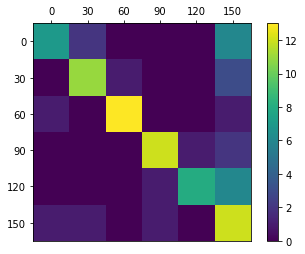

train error: 0.21568627450980393   test error: 0.3


In [536]:
train_err, err = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, oris)
print("train error:", train_err, "  test error:", err)

## max likelihood classification

In [537]:
def max_likelihood_classify(Xc, avgs, stds, oris):
    pre = []
    for response in Xc:
        nlls = []
        for avg, std in zip(avgs, stds):
            nlls.append(np.mean((avg - response)**2 / (2*(std + 0.01)**2) + np.log(std + 0.01)))
        ori_idx = np.argmin(nlls)
        pre.append(oris[ori_idx])

    return pre

In [588]:
def max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, oris, return_minfo=False):
    fit = max_likelihood_classify(Xc_train, avgs, stds, oris)
    train_err = np.sum(fit != labels[train_idxs]) / len(fit)
    
    pre = max_likelihood_classify(Xc_test, avgs, stds, oris)
    err = np.sum(pre != labels[test_idxs]) / len(pre)
        
    conf = metrics.confusion_matrix(labels[test_idxs], pre, labels=oris)
    
    minfo = mutual_info(conf)
    print("mutual information:", minfo)
    
    %matplotlib inline
    plt.figure()
    plt.imshow(conf)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(oris)))
    ax.set_yticks(np.arange(len(oris)))
    ax.set_xticklabels(oris)
    ax.set_yticklabels(oris)
    plt.colorbar()
    plt.show()
    
    if return_minfo:
        return train_err, err, minfo
    return train_err, err

2.3603570831470884
mutual information: 0.8661721756858367


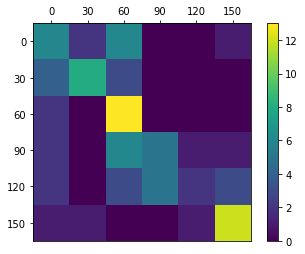

train error: 0.09803921568627451   test error: 0.4888888888888889


In [539]:
train_err, err = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, oris)
print("train error:", train_err, "  test error:", err)

## SVM
- compare with the STA method
- might try normalizing it so no unit is too dominant

In [540]:
from sklearn import svm
from sklearn import metrics

In [587]:
def svm_evaluate(train, test, labels, train_idxs, test_idxs, oris, return_minfo=False):
    clf = svm.SVC(decision_function_shape="ovo")
    clf.fit(train, labels[train_idxs])
    
    fit = clf.predict(train)
    train_err = np.sum(fit != labels[train_idxs]) / len(fit)
    
    pre = clf.predict(test)
    err = np.sum(pre != labels[test_idxs]) / len(pre)
        
    conf = metrics.confusion_matrix(labels[test_idxs], pre, labels=oris)
    
    minfo = mutual_info(conf)
    print("mutual information:", minfo)
    
    %matplotlib inline
    plt.figure()
    plt.imshow(conf)
    ax = plt.gca()
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(oris)))
    ax.set_yticks(np.arange(len(oris)))
    ax.set_xticklabels(oris)
    ax.set_yticklabels(oris)
    plt.colorbar()
    plt.show()
    
    if return_minfo:
        return train_err, err, minfo
    return train_err, err

2.4669211606495463
mutual information: 1.3233825548989684


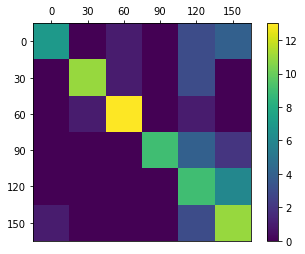

train error: 0.14705882352941177   test error: 0.3333333333333333


In [542]:
train_err, err = svm_evaluate(train, test, labels, train_idxs, test_idxs, oris)
print("train error:", train_err, "  test error:", err)

# Classification of all 6000 gratings
## Get data PCA projections

In [553]:
num_bins = 10
stim_duration = stims.duration.min()  # minimum so that none of the recording periods are overlapping
bin_edges = np.linspace(0, stim_duration, num_bins + 1)
counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                               stimulus_presentation_ids=stims.index,
                                               unit_ids=unit_ids)

In [554]:
Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
labels = np.array(list(stims.orientation))

# train test split
train_frac = 0.7
train_idxs = np.array([], dtype=int)
test_idxs = np.array([], dtype=int)
for label in np.unique(labels):
    matches = np.nonzero(labels == label)[0]
    np.random.shuffle(matches)
    train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
    test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])

In [555]:
Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

In [556]:
proj_rank = 20
train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
test = Xc_test @ Vh.T[:, :proj_rank]

<IPython.core.display.Javascript object>


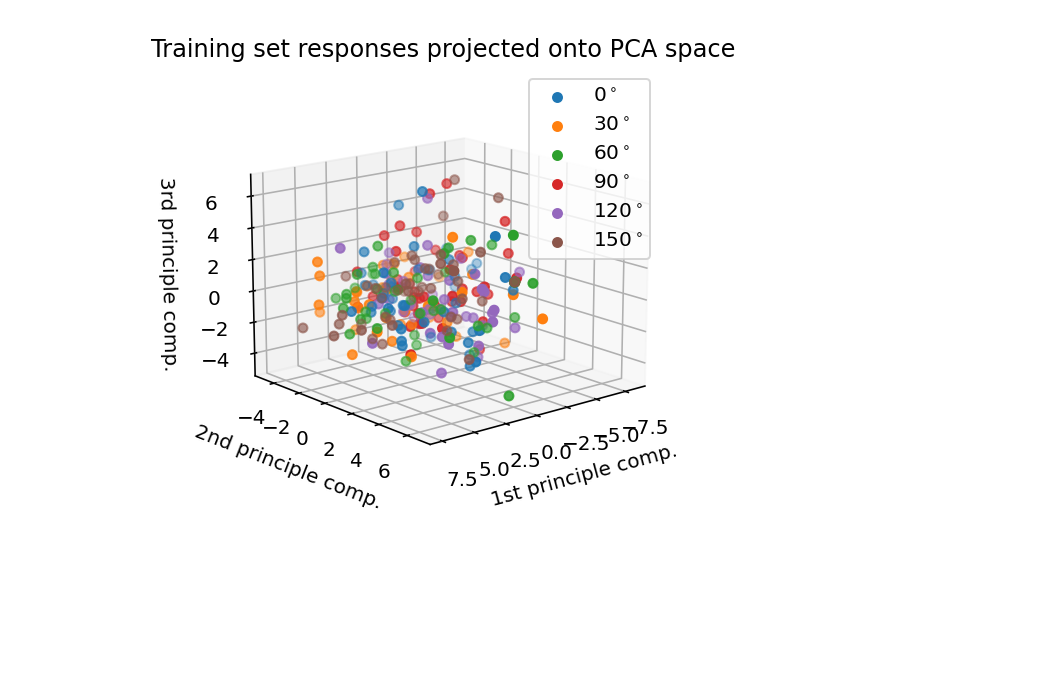

In [557]:
%matplotlib notebook

sample_size = 300
fig = plt.figure(dpi=120)
ax = fig.gca(projection='3d')
plt.title("Training set responses projected onto PCA space")
for ori in oris:
    ori_ims = train[np.nonzero(labels[train_idxs]==ori)[0], :3][:sample_size // len(oris)]
    ax.scatter(ori_ims[:, 0], ori_ims[:, 1], ori_ims[:, 2], label=f"{ori}$^\circ$")
ax.view_init(elev=15, azim=50)
plt.xlabel("1st principle comp.")
plt.ylabel("2nd principle comp.")
ax.set_zlabel("3rd principle comp.")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


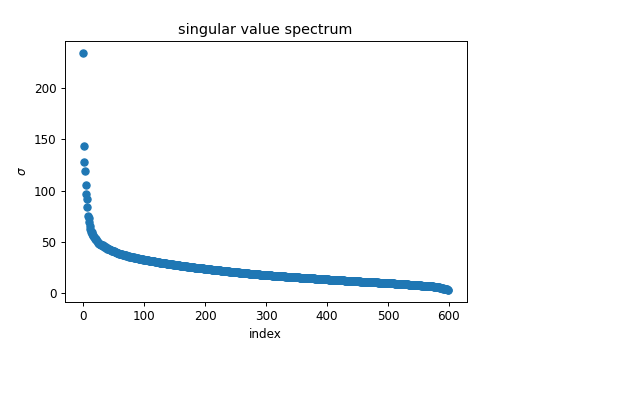

In [558]:
plt.figure()
plt.scatter(np.arange(len(S)), S)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.title("singular value spectrum")
plt.show()

# covariance classification

In [560]:
avgs = []
stds = []
train_avg = np.mean(Xc_train, axis=0)
for ori in oris:
    idxs = np.nonzero(labels[train_idxs]==ori)
    avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
    stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

2.417798551238657
mutual information: 0.25194666494491313


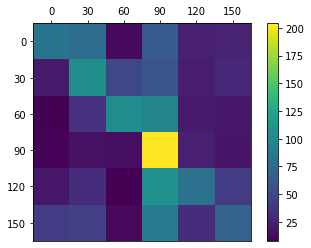

train error: 0.5767338908017707   test error: 0.6292263610315186


In [561]:
train_err, err = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, oris)
print("train error:", train_err, "  test error:", err)

## max likelihood classification

2.4307776782617148
mutual information: 0.41272583001883767


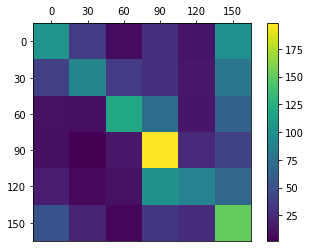

train error: 0.47393015248401377   test error: 0.5684813753581662


In [562]:
train_err, err = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, oris)
print("train error:", train_err, "  test error:", err)

## SVM

2.5230607043738233
mutual information: 0.35347704065863095


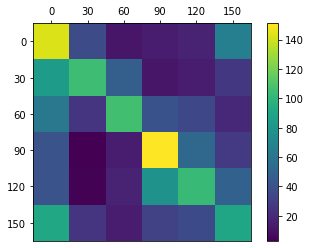

train error: 0.40900147565174616   test error: 0.6


In [563]:
train_err, err = svm_evaluate(train, test, labels, train_idxs, test_idxs, oris)
print("train error:", train_err, "  test error:", err)

# Natural Scene Image Classification
## get data and PCA projections

In [566]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="natural_scenes"]
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
19,5892.415053,6372.832933,480.417880,natural_scenes,9
21,6673.083753,7153.485033,480.401280,natural_scenes,10
27,8024.212413,8552.153375,527.940962,natural_scenes,13


In [567]:
stims = session.get_stimulus_table(["natural_scenes"])
stims

,frame,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,
51353,5,5892.415053,9,natural_scenes,5892.665249,0.250196,4908
51354,114,5892.665249,9,natural_scenes,5892.915445,0.250196,4909
51355,13,5892.915445,9,natural_scenes,5893.165641,0.250196,4910
51356,70,5893.165641,9,natural_scenes,5893.415837,0.250196,4911
51357,26,5893.415837,9,natural_scenes,5893.666049,0.250211,4912
...,...,...,...,...,...,...,...
68222,24,8550.902302,13,natural_scenes,8551.152520,0.250219,5006
68223,107,8551.152520,13,natural_scenes,8551.402739,0.250219,4969
68224,100,8551.402739,13,natural_scenes,8551.652957,0.250219,4924


In [568]:
label_set = np.random.choice(np.arange(118), 6, replace=False)
filtered_stims = stims[list(frame in label_set for frame in stims.frame)]
filtered_stims.shape

(300, 7)

In [569]:
label_set

array([ 2, 93, 69, 84, 40, 78])

Each image was shown 50 times

In [570]:
num_bins = 10
stim_duration = filtered_stims.duration.min()  # minimum so that none of the recording periods are overlapping
bin_edges = np.linspace(0, stim_duration, num_bins + 1)
counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                               stimulus_presentation_ids=filtered_stims.index,
                                               unit_ids=unit_ids)

In [571]:
Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
labels = np.array(list(filtered_stims.frame))

# train test split
train_frac = 0.7
train_idxs = np.array([], dtype=int)
test_idxs = np.array([], dtype=int)
for label in label_set:
    matches = np.nonzero(labels == label)[0]
    np.random.shuffle(matches)
    train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
    test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])

In [572]:
Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

In [573]:
proj_rank = 20
train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
test = Xc_test @ Vh.T[:, :proj_rank]

# Analysis of redundancy

In [ ]:
# pca on the overall average response to natural images

# Analysis of redundancy

In [ ]:
# pca on the overall average response to natural images

<IPython.core.display.Javascript object>


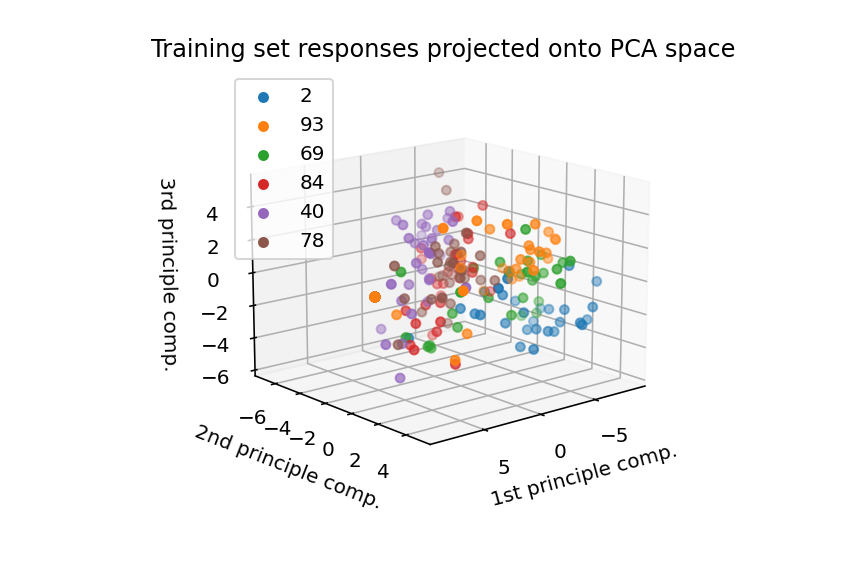

In [574]:
%matplotlib notebook
sample_size = 2000
fig = plt.figure(dpi=120)
ax = fig.gca(projection='3d')
plt.title("Training set responses projected onto PCA space")
# for ori in oris[[1,3]]:
for lab in label_set:
    lab_resp = train[np.nonzero(labels[train_idxs]==lab)[0], :3][:sample_size // len(label_set)]
    ax.scatter(lab_resp[:, 0], lab_resp[:, 1], lab_resp[:, 2], label=f"{lab}")
ax.view_init(elev=15, azim=50)
plt.xlabel("1st principle comp.")
plt.ylabel("2nd principle comp.")
ax.set_zlabel("3rd principle comp.")
plt.legend()
plt.show()

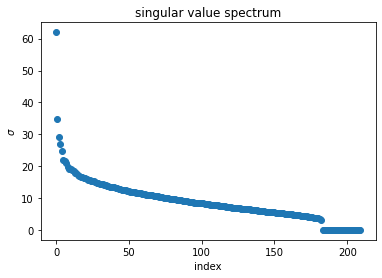

In [576]:
%matplotlib inline
plt.figure()
plt.scatter(np.arange(len(S)), S)
plt.xlabel("index")
plt.ylabel("$\sigma$")
plt.title("singular value spectrum")
plt.show()

In [577]:
S[183], S[184]

(2.8638145908427635e-14, 1.1744570672829882e-14)

## covariance classification

In [578]:
avgs = []
stds = []
train_avg = np.mean(Xc_train, axis=0)
for lab in label_set:
    idxs = np.nonzero(labels[train_idxs]==lab)
    avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
    stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

2.5201888129663126
mutual information: 1.3725255219915065


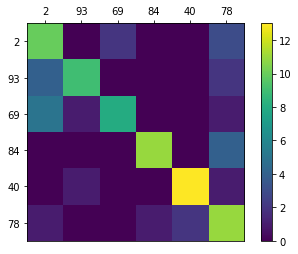

train error: 0.1523809523809524   test error: 0.3111111111111111


In [579]:
train_err, err = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, label_set)
print("train error:", train_err, "  test error:", err)

## max likelihood classification

2.3747357117519208
mutual information: 0.6664306188794449


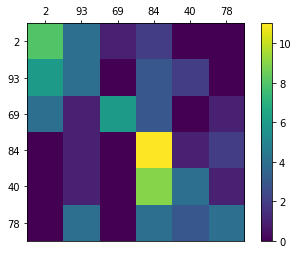

train error: 0.10476190476190476   test error: 0.5888888888888889


In [580]:
train_err, err = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, label_set)
print("train error:", train_err, "  test error:", err)

## SVM classification

2.5009999493086386
mutual information: 1.38106606881859


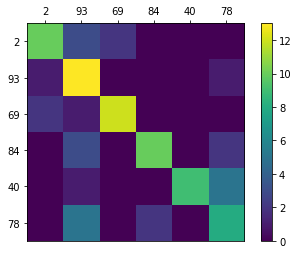

train error: 0.11428571428571428   test error: 0.3111111111111111


In [581]:
train_err, err = svm_evaluate(train, test, labels, train_idxs, test_idxs, label_set)
print("train error:", train_err, "  test error:", err)

# Classification accuracy versus number of images

In [582]:
nums_included = np.logspace(0.4, 2.07, 10, base=10).astype(int)
nums_included

array([  2,   3,   5,   9,  13,  21,  32,  49,  76, 117])

NUM INCLUDED -------  2
COVARIANCE
0.9967627783706421
mutual information: 0.536857210592589


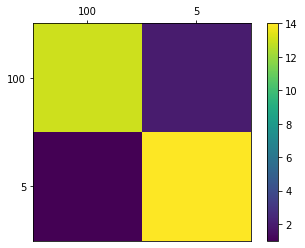

train error: 0.14285714285714285   test error: 0.1
MAX LIKELIHOOD
0.7218992414373739
mutual information: 0.08610051005833586


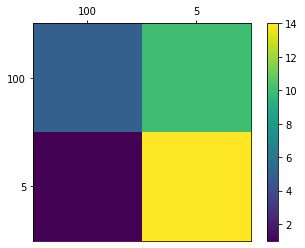

train error: 0.04285714285714286   test error: 0.36666666666666664
SVM
0.9999711463877176
mutual information: 0.9999855732659922


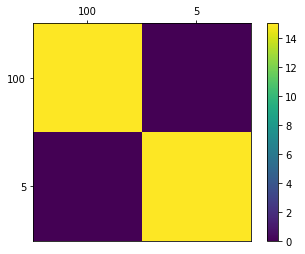

train error: 0.04285714285714286   test error: 0.0
NUM INCLUDED -------  3
COVARIANCE
1.5783494531153521
mutual information: 0.2020422035820395


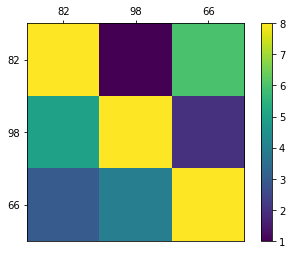

train error: 0.1523809523809524   test error: 0.4666666666666667
MAX LIKELIHOOD
1.4662832301045172
mutual information: 0.3496083803364296


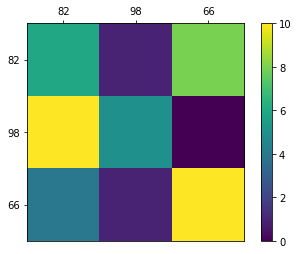

train error: 0.09523809523809523   test error: 0.5333333333333333
SVM
1.5408036247996058
mutual information: 0.34815554176164


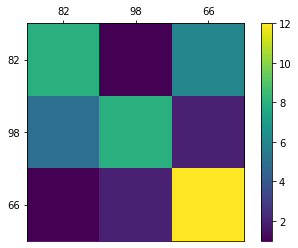

train error: 0.10476190476190476   test error: 0.37777777777777777
NUM INCLUDED -------  5
COVARIANCE
2.2617427404191015
mutual information: 1.187100314140963


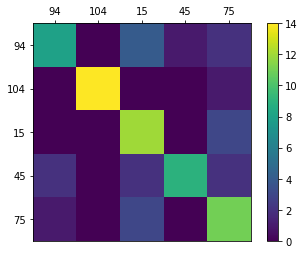

train error: 0.24   test error: 0.28
MAX LIKELIHOOD
2.22534443423673
mutual information: 1.0874767690212646


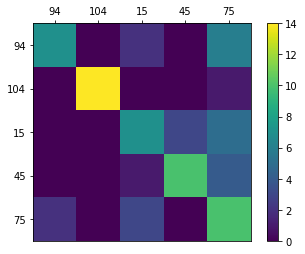

train error: 0.12   test error: 0.36
SVM
2.2756297265570353
mutual information: 1.3386742477358418


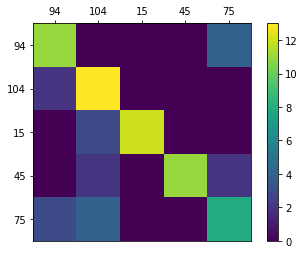

train error: 0.12571428571428572   test error: 0.26666666666666666
NUM INCLUDED -------  9
COVARIANCE
2.8000086233653865
mutual information: 1.2645677687758907


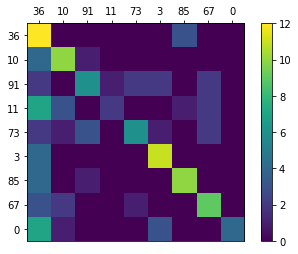

train error: 0.30793650793650795   test error: 0.48148148148148145
MAX LIKELIHOOD
2.720809141292
mutual information: 0.953693756191931


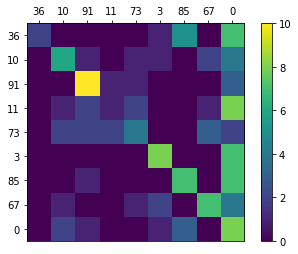

train error: 0.14603174603174604   test error: 0.6074074074074074
SVM
3.0195219261561825
mutual information: 1.397438578330537


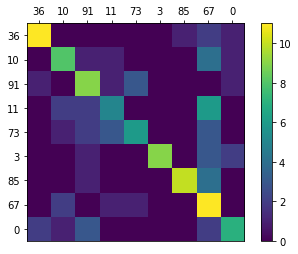

train error: 0.20952380952380953   test error: 0.43703703703703706
NUM INCLUDED -------  13
COVARIANCE
3.0502363474183274
mutual information: 1.5458572497585379


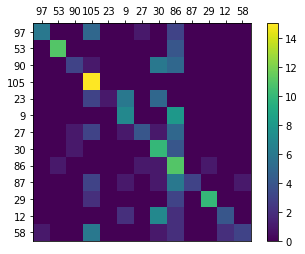

train error: 0.36043956043956044   test error: 0.5487179487179488
MAX LIKELIHOOD
3.5133266756104136
mutual information: 1.2929422982172212


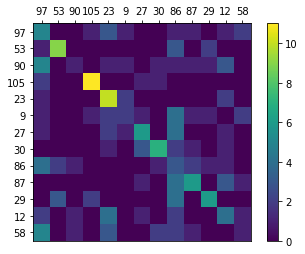

train error: 0.09010989010989011   test error: 0.6358974358974359
SVM
3.5414998151041166
mutual information: 1.925950410006196


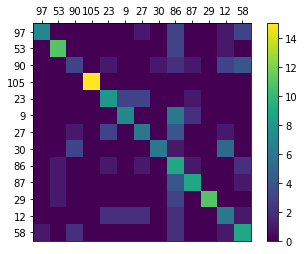

train error: 0.18021978021978022   test error: 0.4512820512820513
NUM INCLUDED -------  21
COVARIANCE
3.7343508200695403
mutual information: 1.8115049244166939


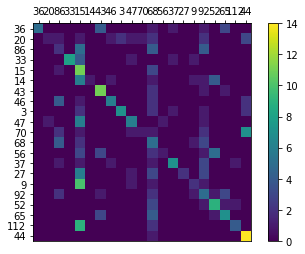

train error: 0.4312925170068027   test error: 0.6349206349206349
MAX LIKELIHOOD
3.966237666480766
mutual information: 1.4499287078964982


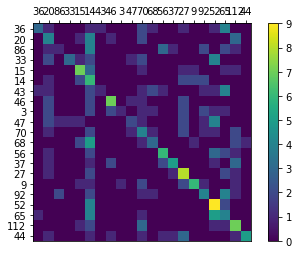

train error: 0.13741496598639455   test error: 0.6952380952380952
SVM
4.170407103278768
mutual information: 2.1407415063133617


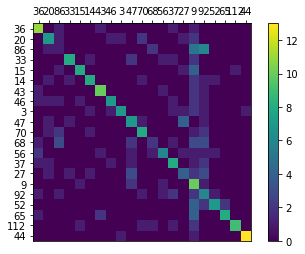

train error: 0.2802721088435374   test error: 0.5079365079365079
NUM INCLUDED -------  32
COVARIANCE
4.231747085092103
mutual information: 2.1968061216056354


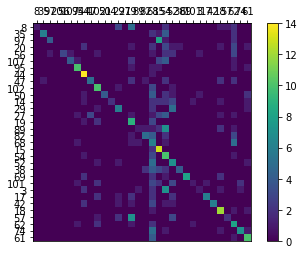

train error: 0.3991071428571429   test error: 0.6145833333333334
MAX LIKELIHOOD
4.57517295962313
mutual information: 1.8603863258916764


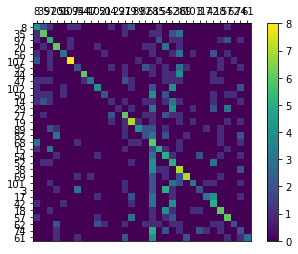

train error: 0.125   test error: 0.7145833333333333
SVM
4.741737517416303
mutual information: 2.6228426258647968


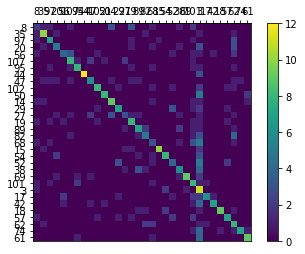

train error: 0.2580357142857143   test error: 0.5229166666666667
NUM INCLUDED -------  49
COVARIANCE
4.5249864515337785
mutual information: 2.174788973774505


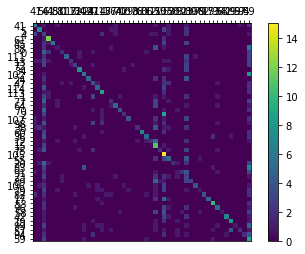

train error: 0.5090379008746355   test error: 0.7020408163265306
MAX LIKELIHOOD
5.241785744293264
mutual information: 2.295035878163469


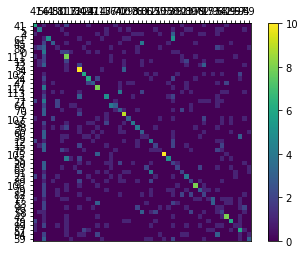

train error: 0.14402332361516035   test error: 0.7619047619047619
SVM
5.255063304527571
mutual information: 2.595433903087486


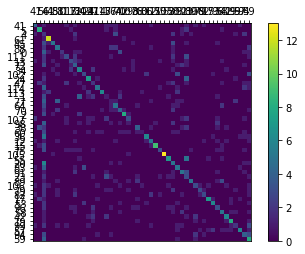

train error: 0.3830903790087464   test error: 0.6816326530612244
NUM INCLUDED -------  76
COVARIANCE
4.7492644064012355
mutual information: 2.1748605655133186


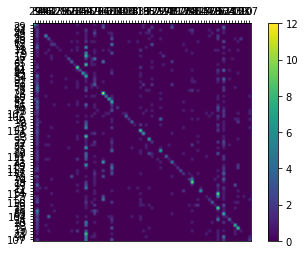

train error: 0.6251879699248121   test error: 0.7982456140350878
MAX LIKELIHOOD
5.683504961969389
mutual information: 2.4797661855032818


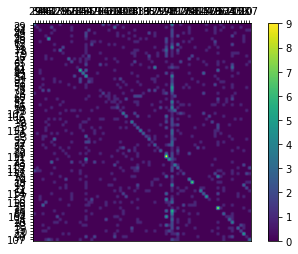

train error: 0.17030075187969926   test error: 0.8543859649122807
SVM
5.829913094759997
mutual information: 2.8518740644389737


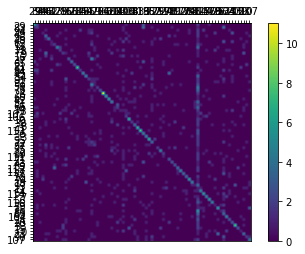

train error: 0.468796992481203   test error: 0.7631578947368421
NUM INCLUDED -------  117
COVARIANCE
4.893031549441907
mutual information: 2.5404917710470936


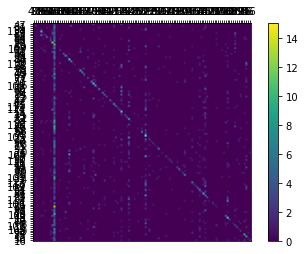

train error: 0.6085470085470085   test error: 0.7971509971509971
MAX LIKELIHOOD
6.2622582826194515
mutual information: 2.941752609552143


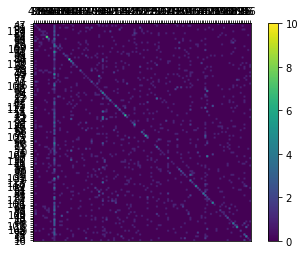

train error: 0.16996336996336997   test error: 0.8592592592592593
SVM
6.354058550263727
mutual information: 3.2484233003593275


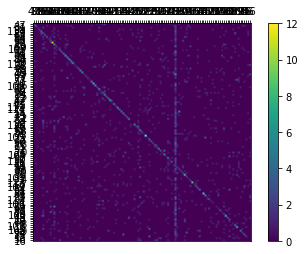

train error: 0.484981684981685   test error: 0.788034188034188


In [589]:
errs_cov = []
errs_ml = []
errs_svm = []
minfos = []

for num_included in nums_included:
    print("NUM INCLUDED ------- ", num_included)
    label_set = np.random.choice(np.arange(118), num_included, replace=False)
    filtered_stims = stims[list(frame in label_set for frame in stims.frame)]
    
    stim_duration = filtered_stims.duration.min()  # minimum so that none of the recording periods are overlapping
    bin_edges = np.linspace(0, stim_duration, num_bins + 1)
    counts = session.presentationwise_spike_counts(bin_edges=bin_edges,
                                                   stimulus_presentation_ids=filtered_stims.index,
                                                   unit_ids=unit_ids)
    
    Xall = np.reshape(np.array(counts), (counts.shape[0], num_bins * len(unit_ids)))
    labels = np.array(list(filtered_stims.frame))

    # train test split
    train_frac = 0.7
    train_idxs = np.array([], dtype=int)
    test_idxs = np.array([], dtype=int)
    for label in label_set:
        matches = np.nonzero(labels == label)[0]
        np.random.shuffle(matches)
        train_idxs = np.concatenate([train_idxs, matches[:int(train_frac * len(matches))]])
        test_idxs = np.concatenate([test_idxs, matches[int(train_frac * len(matches)):]])
        
    Xc_train = Xall[train_idxs] - np.mean(Xall[train_idxs], axis=0, keepdims=True)
    Xc_test = Xall[test_idxs] - np.mean(Xall[test_idxs], axis=0, keepdims=True)
    U, S, Vh = np.linalg.svd(Xc_train, full_matrices=False)

    proj_rank = 20
    train = (np.diag(S[:proj_rank]) @ U.T[:proj_rank]).T
    test = Xc_test @ Vh.T[:, :proj_rank]

    avgs = []
    stds = []
    train_avg = np.mean(Xc_train, axis=0)
    for lab in label_set:
        idxs = np.nonzero(labels[train_idxs]==lab)
        avgs.append(np.mean(Xc_train[idxs] - train_avg, axis=0))
        stds.append(np.std(Xc_train[idxs] - train_avg, axis=0))

    print("COVARIANCE")
    train_err, err, minfo_cov = covar_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, label_set, return_minfo=True)
    errs_cov.append(err)
    print("train error:", train_err, "  test error:", err)

    print("MAX LIKELIHOOD")
    train_err, err, minfo_ml = max_likelihood_evaluate(Xc_train, Xc_test, labels, train_idxs, test_idxs, avgs, stds, label_set, return_minfo=True)
    errs_ml.append(err)
    print("train error:", train_err, "  test error:", err)

    print("SVM")
    train_err, err, minfo_svm = svm_evaluate(train, test, labels, train_idxs, test_idxs, label_set, return_minfo=True)
    errs_svm.append(err)
    print("train error:", train_err, "  test error:", err)
    
    minfos.append(max(minfo_cov, minfo_ml, minfo_svm))

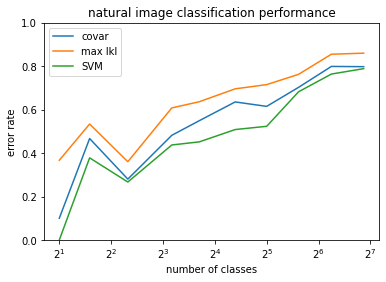

In [596]:
plt.figure()
plt.plot(nums_included, errs_cov, label="covar")
plt.plot(nums_included, errs_ml, label="max lkl")
plt.plot(nums_included, errs_svm, label="SVM")
plt.ylim([0, 1])
plt.ylabel("error rate")
plt.xlabel("number of classes")
plt.title("natural image classification performance")
plt.semilogx(base=2)
plt.legend()
plt.show()

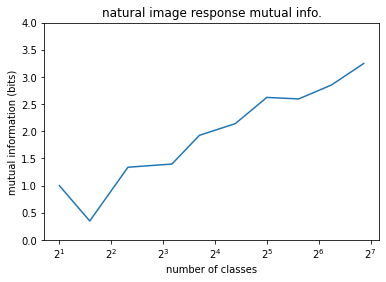

In [595]:
plt.figure()
plt.plot(nums_included, minfos)
plt.ylim([0, 4])
plt.ylabel("mutual information (bits)")
plt.xlabel("number of classes")
plt.title("natural image response mutual info.")
plt.semilogx(base=2)
plt.show()

# Analysis of redundancy

In [1]:
# pca on the overall average response to natural movies

In [222]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs = stim_epochs[stim_epochs.stimulus_name=="natural_movie_three"]
stim = session.get_stimulus_table(['natural_movie_three'])
stim_pres_ids = stim.index

In [223]:
stim

,contrast,frame,orientation,size,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,
3999,1,0,0,"[1920.0, 1080.0]",2205.301633,3,natural_movie_three,2205.334993,0.033360,287
4000,1,1,0,"[1920.0, 1080.0]",2205.334993,3,natural_movie_three,2205.368354,0.033360,288
4001,1,2,0,"[1920.0, 1080.0]",2205.368354,3,natural_movie_three,2205.401714,0.033360,289
4002,1,3,0,"[1920.0, 1080.0]",2205.401714,3,natural_movie_three,2205.435075,0.033360,290
4003,1,4,0,"[1920.0, 1080.0]",2205.435075,3,natural_movie_three,2205.468435,0.033360,291
...,...,...,...,...,...,...,...,...,...,...
49197,1,3595,0,"[1920.0, 1080.0]",4667.224934,6,natural_movie_three,4667.258296,0.033362,3882
49198,1,3596,0,"[1920.0, 1080.0]",4667.258296,6,natural_movie_three,4667.291657,0.033362,3883
49199,1,3597,0,"[1920.0, 1080.0]",4667.291657,6,natural_movie_three,4667.325019,0.033362,3884


In [224]:
times = session.presentationwise_spike_times(stimulus_presentation_ids=stim_pres_ids, # is this right? todo
                                             unit_ids=unit_ids)

In [239]:
num_bins = 3000
# stim_length = 30  # seconds for natural movie one
stim_length = 120  # seconds for natural movie three
stim_range = np.array([0, stim_length])

trials = np.zeros((20, num_bins, len(unit_ids)))  # stimulus was presented 20 times
bin_edges = np.linspace(0, stim_length, num_bins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
bin_width = bin_edges[1] - bin_edges[0]

for j, unit_id in enumerate(unit_ids):
    # 1st block where nat 1 is shown, it is shown 10 times in each block
    presentations1 = stim_epochs.iloc[0].start_time + np.linspace(0, stim_epochs.iloc[0].duration, 10)
    # 2nd block
    presentations2 = stim_epochs.iloc[1].start_time + np.linspace(0, stim_epochs.iloc[1].duration, 10)
    presentations = np.concatenate([presentations1, presentations2])
    for i, start in enumerate(presentations):
        times_ij = times[(times.unit_id==unit_id) & (start < times.index) & (times.index < (start + stim_length))].index
        unit_counts, _ = np.histogram(times_ij, num_bins, range=start + stim_range)
        trials[i, :, j] = unit_counts

In [240]:
avg_resp = trials.mean(axis=0)
avg_resp_c = avg_resp - avg_resp.mean(axis=0, keepdims=True)

In [241]:
U, S, Vh = np.linalg.svd(avg_resp_c, full_matrices=False)

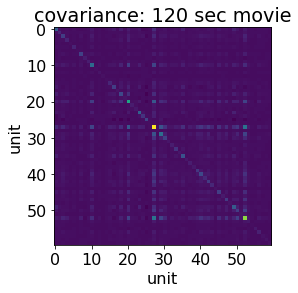

In [252]:
cov = avg_resp_c.T @ avg_resp_c / (avg_resp_c.shape[1] - 1)
plt.imshow(cov)
plt.title("covariance: 120 sec movie")
plt.ylabel("unit")
plt.xlabel("unit")
plt.xticks(range(0, 60 ,10))
plt.show()

In [243]:
cov[27, 52]

2.7098637429378525

(5.0, 85.0)

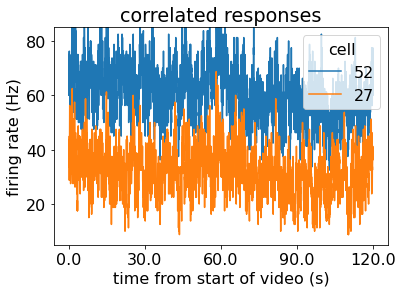

In [244]:
plt.plot(avg_resp[:, [27, 52]] * num_bins / stim_length)
ticks = np.linspace(0, num_bins, 5).astype(int)
plt.xticks(ticks)
ax = plt.gca()
ax.set_xticklabels(np.round(bin_edges[ticks], 3))
plt.ylabel("firing rate (Hz)")
plt.xlabel("time from start of video (s)")
plt.title("correlated responses")
plt.legend(title="cell", labels=[52, 27], loc="upper right")
plt.ylim([5, 85])

In [245]:
variances = S**2 / (avg_resp_c.shape[1] - 1)
cumul_var = sum(variances)
cumul_vars = [0]
rank_hat = None
for i, var in enumerate(variances):
    cumul_vars.append(var + cumul_vars[-1])
    if rank_hat is None and cumul_vars[-1] / cumul_var > 0.9:
        rank_hat = i
rank_hat

27

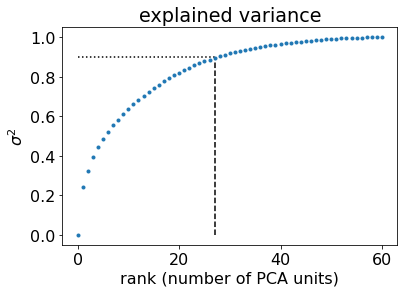

In [246]:
plt.plot(cumul_vars / cumul_vars[-1], ".")
plt.xlabel("rank (number of PCA units)")
plt.hlines(0.9, 0, rank_hat, linestyle=":", color="k")
plt.vlines(rank_hat, 0, 0.9, linestyle="--", color="k")
plt.ylabel("$\sigma^2$")
plt.title("explained variance")
plt.show()

In [247]:
rank_hat

27

In [248]:
avg_resp[:, 27].mean()

2.4526833333333333

## robustness of PCA rank

In [236]:
nums_bins = np.array([50, 100, 200, 350, 500, 750, 1000, 1500, 2000, 5000, 10000, 20000, 50000])
rank_hats = []

In [237]:
for num_bins in nums_bins:
    print("NUM BINS", num_bins)
    stim_length = 30  # seconds for natural movie one
    stim_range = np.array([0, stim_length])

    trials = np.zeros((20, num_bins, len(unit_ids)))  # stimulus was presented 20 times
    bin_edges = np.linspace(0, stim_length, num_bins + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    for j, unit_id in enumerate(unit_ids):
        # 1st block where nat 1 is shown, it is shown 10 times in each block
        presentations1 = stim_epochs.iloc[0].start_time + np.linspace(0, stim_epochs.iloc[0].duration, 10)
        # 2nd block
        presentations2 = stim_epochs.iloc[1].start_time + np.linspace(0, stim_epochs.iloc[1].duration, 10)
        presentations = np.concatenate([presentations1, presentations2])
        for i, start in enumerate(presentations):
            times_ij = times[(times.unit_id==unit_id) & (start < times.index) & (times.index < (start + stim_length))].index
            unit_counts, _ = np.histogram(times_ij, num_bins, range=start + stim_range)
            trials[i, :, j] = unit_counts

    avg_resp = trials.mean(axis=0)
    avg_resp_c = avg_resp - avg_resp.mean(axis=0, keepdims=True)

    U, S, Vh = np.linalg.svd(avg_resp_c, full_matrices=False)

    variances = S**2 / (avg_resp_c.shape[1] - 1)
    cumul_var = sum(variances)
    cumul_vars = [0]
    rank_hat = None
    for i, var in enumerate(variances):
        cumul_vars.append(var + cumul_vars[-1])
        if rank_hat is None and cumul_vars[-1] / cumul_var > 0.9:
            rank_hat = i
    rank_hats.append(rank_hat)

NUM BINS 50
NUM BINS 100
NUM BINS 200
NUM BINS 350
NUM BINS 500
NUM BINS 750
NUM BINS 1000
NUM BINS 1500
NUM BINS 2000
NUM BINS 5000
NUM BINS 10000
NUM BINS 20000
NUM BINS 50000


Text(0, 0.5, 'PCA-estimated rank')

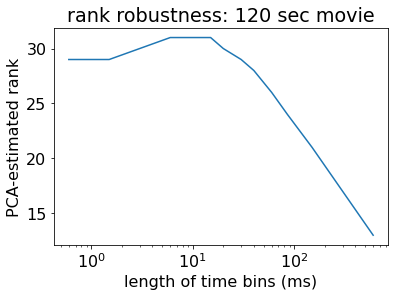

In [250]:
plt.plot(1000 * 30 / nums_bins, rank_hats)
plt.xlabel("length of time bins (ms)")
plt.title("rank robustness: 120 sec movie")
plt.semilogx()
plt.ylabel("PCA-estimated rank")

In [188]:
unit52 = units[units.index == unit_ids[52]]

In [193]:
unit27 = units[units.index == unit_ids[27]]

In [194]:
print(unit27['anterior_posterior_ccf_coordinate'])
print(unit27['dorsal_ventral_ccf_coordinate'])
unit27['left_right_ccf_coordinate']

id
950931254    8636.0
Name: anterior_posterior_ccf_coordinate, dtype: float64
id
950931254    1219.0
Name: dorsal_ventral_ccf_coordinate, dtype: float64


id
950931254    8183.0
Name: left_right_ccf_coordinate, dtype: float64

In [189]:
print(unit52['anterior_posterior_ccf_coordinate'])
print(unit52['dorsal_ventral_ccf_coordinate'])
unit52['left_right_ccf_coordinate']

id
950932563    8730.0
Name: anterior_posterior_ccf_coordinate, dtype: float64
id
950932563    808.0
Name: dorsal_ventral_ccf_coordinate, dtype: float64


id
950932563    8134.0
Name: left_right_ccf_coordinate, dtype: float64